In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 (本番用) ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/longformer-base-4096"
OUTPUT_MODEL_DIR = "models/cencoder_bce_v1" # 本番用の保存先

# --- 実験計画からのハイパーパラメータ ---
MAX_LENGTH = 2048
LEARNING_RATE = 2e-5
EPOCHS = 3       # ▼▼▼ 3エポックで実験 ▼▼▼
BATCH_SIZE = 32  # ▼▼▼ バッチサイズ32 ▼▼▼
GRAD_ACCUM_STEPS = 2 # ▼▼▼ 勾配累積2 (実質バッチ 32*2=64) ▼▼▼

print(f"Configuration set for PRODUCTION (Batch Size: {BATCH_SIZE}, Grad Accum: {GRAD_ACCUM_STEPS}, Epochs: {EPOCHS})")

Configuration set for PRODUCTION (Batch Size: 32, Grad Accum: 2, Epochs: 3)


In [3]:
# --- 3. モデル ---
# C-Encoder (BCE) は、Hugging Face標準の AutoModelForSequenceClassification を
# num_labels=1 でロードすることで実装できます。
# そのため、このセルではカスタムクラスの定義は不要です。
print("Model: Standard AutoModelForSequenceClassification (num_labels=1)")

Model: Standard AutoModelForSequenceClassification (num_labels=1)


In [4]:
# --- 4. データセットの読み込みとトークン化 ---
print(f"Loading full dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])

# ラベルをBCE用にfloat型に変換
df_full['label'] = df_full['label'].astype(float) 
print(f"Full dataset size: {len(df_full)}")

# 全データセットを使用
raw_dataset = Dataset.from_pandas(df_full)
# 本番なので、検証データ(validation)も多め(20%)に確保
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Dataset loaded: {dataset}")

# --- トークナイズ ---
print("Initializing Longformer tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_nsp_function(examples):
    # 入力: [CLS] abstract_a [SEP] abstract_b [SEP]
    return tokenizer(
        examples["abstract_a"], 
        examples["abstract_b"], 
        padding="max_length", 
        truncation=True, 
        max_length=MAX_LENGTH # 2048に設定
    )

print(f"Tokenizing dataset (max_length={MAX_LENGTH})...")
tokenized_datasets = dataset.map(tokenize_nsp_function, batched=True, num_proc=4)

tokenized_datasets = tokenized_datasets.remove_columns(["abstract_a", "abstract_b", "data_paper_doi"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Loading full dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 27699
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 6925
    })
})
Initializing Longformer tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset (max_length=2048)...


Map (num_proc=4):   0%|          | 0/27699 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6925 [00:00<?, ? examples/s]

Tokenization complete.


In [5]:
# --- 5. モデルのロードと訓練設定 ---
print(f"Loading model: {MODEL_CHECKPOINT}")
# num_labels=1 に設定 (BCEWithLogitsLossが自動で使われる)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=1 
).to(device)
print("Model loaded.")

# 評価指標を計算する関数 (BCE用)
def compute_metrics_bce(eval_pred):
    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    labels = labels.astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, # 32
    per_device_eval_batch_size=BATCH_SIZE,  # 32
    gradient_accumulation_steps=GRAD_ACCUM_STEPS, # 2
    num_train_epochs=EPOCHS, # 3
    weight_decay=0.01,
    evaluation_strategy="epoch", # エポックごとに評価
    save_strategy="epoch",       # エポックごとに保存
    load_best_model_at_end=True, # 最高のモデルを最後にロード
    logging_strategy="steps",
    logging_steps=100,           # 100ステップごとにログ表示
    warmup_ratio=0.1,            # 10%ウォームアップ
    gradient_checkpointing=True, # メモリ節約
)
print("Training arguments set for PRODUCTION.")

Loading model: allenai/longformer-base-4096


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.
Training arguments set for PRODUCTION.


In [6]:
# --- 5-2. 重み付き損失のためのカスタムTrainerを定義 ---

class WeightedBCETrainer(Trainer):
    """
    pos_weight 付きの BCEWithLogitsLoss を計算するために Trainer を継承。
    """
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        損失計算メソッドをオーバーライドします。
        """
        # 1. Hugging Faceのデータセットからラベルを分離します
        labels = inputs.pop("labels")
        
        # 2. モデルの順伝播を実行します
        # outputs.logits にモデルの生の出力（logit）が含まれます
        outputs = model(**inputs)
        logits = outputs.logits
        
        # 3. クラスの重みを定義します
        #    データセットの負例：正例の比率が約4:1なので、
        #    正例の重みを4.0に設定します。
        #    これにより、モデルが正例を間違えた際のペナルティが4倍になります。
        pos_weight = torch.tensor([4.0], device=self.args.device)
        
        # 4. 重み付きのBCE損失関数をインスタンス化します
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # 5. 損失を計算します
        #    モデルの出力(logits)とラベルの形状を[batch_size]に合わせるために .view(-1) を使います
        loss = loss_fct(logits.view(-1), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

print("✅ Custom 'WeightedBCETrainer' defined for handling class imbalance.")

✅ Custom 'WeightedBCETrainer' defined for handling class imbalance.


In [7]:
# --- 6. 訓練の開始 ---

# 標準の Trainer の代わりに、上で定義した WeightedBCETrainer を使用します
trainer = WeightedBCETrainer(  # <- ここを変更！
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_bce
)

print("\n--- Starting Model Training (C-Encoder BCE with pos_weight) ---")
trainer.train()
print("--- Model Training Complete ---")


--- Starting Model Training (C-Encoder BCE with pos_weight) ---


Initializing global attention on CLS token...
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.213700,0.149818,0.960144,0.907877,0.843672,0.982659
2,0.118600,0.168959,0.982527,0.956016,0.961960,0.950145
3,0.059000,0.119509,0.986282,0.966156,0.952916,0.979769


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


--- Model Training Complete ---


In [8]:
# --- 7. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

Training complete. Saving best model...
Model saved to models/cencoder_bce_v1/best_model



--- Visualizing Training Results ---


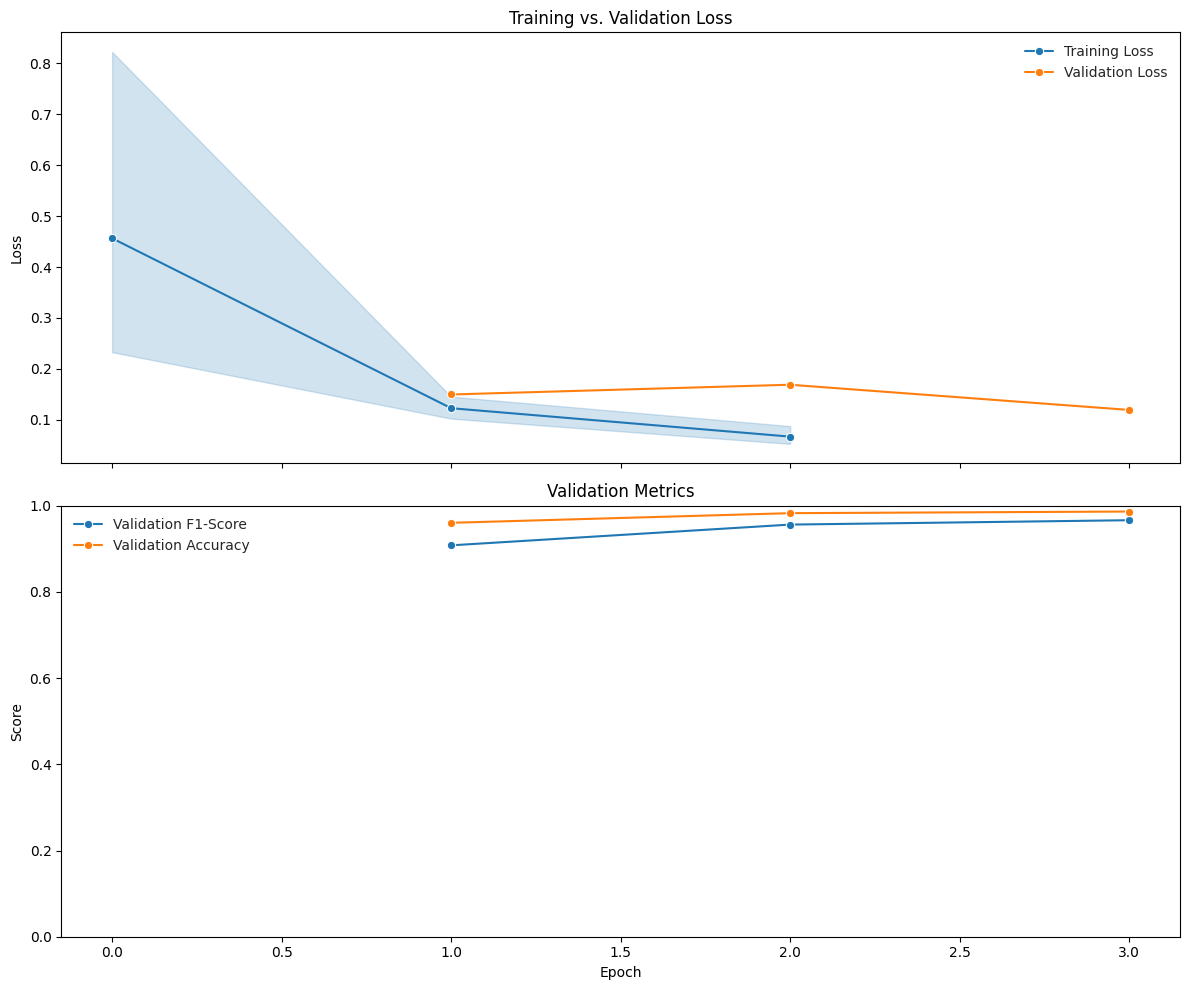


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch (based on min eval_loss): 3.0
Best Validation Loss: 0.1195
Best Validation F1: 0.9662
Best Validation Accuracy: 0.9863


In [9]:
# --- 8. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

# 'epoch'列を整数型に（表示のため）
if 'epoch' in df_train.columns:
    df_train['epoch'] = df_train['epoch'].astype(int)
if 'epoch' in df_eval.columns:
    df_eval['epoch'] = df_eval['epoch'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o')
    sns.lineplot(data=df_eval, x='epoch', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Score')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Epoch (based on min eval_loss): {best_run['epoch']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation F1: {best_run['eval_f1']:.4f}")
    print(f"Best Validation Accuracy: {best_run['eval_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")